In [2]:
import numpy as np
import numpy.random as random
import pandas as pd
import scipy as sp
from pandas import Series, DataFrame

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set()

import sklearn
import requests, zipfile
import io

import statsmodels.api as sm

__정규화 선형회귀__

---


정규화(regularized) 선형회귀 방법은 선형회귀 계수(weight)에 대한 제약 조건을 추가함으로써 모형이 과도하게 최적화되는 현상, 즉 과최적화를 막는 방법이다. Regularized Method, Penalized Method, Contrained Least Squares 이라고도 불리운다.

모형이 과도하게 최적화되면 모형 계수의 크기도 과도하게 증가하는 경향이 나타난다. 따라서 정규화 방법에서 추가하는 제약 조건은 일반적으로 계수의 크기를 제한하는 방법이다. 일반적으로 다음과 같은 세가지 방법이 사용된다.

* Ridge 회귀모형
* Lasso 회귀모형
* Elastic Net 회귀모형

<p>&nbsp;</p>

__Ridge 회귀모형__

---

Ridge 회귀모형에서는 가중치들의 제곱합(squared sum of weights)을 최소화하는 것을 추가적인 제약 조건으로 한다.

$$
w = \text{arg}\min_w \left( \sum^N_{i=1}e^2_i + \lambda \sum^M_{j=1}w^2_j\right)
$$

$\lambda$는 기존의 잔차 제곱합과 추가적 제약 조건의 비중을 조절하기 위한 하이퍼 모수(hyper parameter)이다. $\lambda$가 크면 정규화 정도가 커지고 가중치의 값들이 작아진다. $\lambda$가 작아지면 정규화 정도가 작아지며 $\lambda$가 0이 되면 일반적인 선형 회귀모형이 된다.

<p>&nbsp;<p>

__Lasso 회귀모형__

---

Lasso(Least Absolute Shrinkage and Selection Operator) 회귀모형은 가중치의 절대값의 합을 최소화하는 것을 추가적인 제약 조건으로 한다.

$$
w = \text{arg} \min_w \left( \sum^N_{i=1} e^2_i + \lambda \sum^M_{j=1} |w_j| \right)
$$

<p>&nbsp;</p>

__Elastic Net 회귀모형__

---

Elastci Net 회귀모형은 가중치의 절대값의 합과 제곱합을 동시에 제약 조건으로 가지는 모형이다.

$$
w = \text{arg} \min_w \left( \sum^N_{i=1} e^2_i + \lambda_1 \sum^M_{j=1} |w_j| + \lambda_2 \sum^M_{j=1} w^2_j \right)
$$

$\lambda_1$, $\lambda_2$ 두 개의 하이퍼 모수를 가진다.

<p>&nbsp;</p>

__statsmodels의 정규화 회귀모형__

---

statsmodels 패키지는 OLS 선형 회귀모형 클래스의 `fit_regularized` 메서드를 사용하여 Elastic Net 모형 계수를 구할 수 있다.

하이퍼 모수는 다음과 같이 모수 $\text{alpha}$와 $\text{L1} \_ \text{wt}$로 정의된다.

$$
0.5 \times \text{RSS} / \text{alpha} \times (0.5 \times (1 - \text{L1} \_ \text{wt}) \sum w^2_i + \text{L1} \_ \text{wt} \sum |w_i|)

In [3]:
def make_nonlinear(seed=0):
    np.random.seed(seed)
    n_samples = 30
    X = np.sort(np.random.rand(n_samples))
    y = np.sin(2 * np.pi * X) + np.random.randn(n_samples) * 0.1
    X = X[:, np.newaxis]
    return (X, y)

X, y = make_nonlinear()
dfX = pd.DataFrame(X, columns=["x"])
dfX = sm.add_constant(dfX)
dfy = pd.DataFrame(y, columns=["y"])
df = pd.concat([dfX, dfy], axis = 1)

In [4]:
model = sm.OLS.from_formula(
     "y ~ x + I(x**2) + I(x**3) + I(x**4) + I(x**5) + I(x**6) + I(x**7) + I(x**8) + I(x**9)", data=df)

result1 = model.fit()
result1.params

Intercept       -0.169863
x               25.735773
I(x ** 2)     -428.141683
I(x ** 3)     3866.723113
I(x ** 4)   -18340.939658
I(x ** 5)    49326.072530
I(x ** 6)   -78884.743049
I(x ** 7)    74538.645130
I(x ** 8)   -38453.132179
I(x ** 9)     8350.254983
dtype: float64

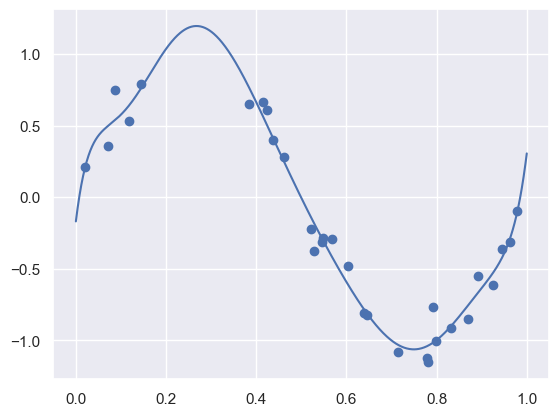

In [5]:
def plot_statsmodels(result):
    plt.scatter(X, y)
    xx = np.linspace(0, 1, 1000)
    dfxx = pd.DataFrame(xx, columns=["x"])
    dfxx = sm.add_constant(dfxx)
    plt.plot(xx, result.predict(dfxx).values)
    plt.show()

plot_statsmodels(result1)

모수 `L1_wt`가 0이면 순수 Ridge 모형이 된다.

[ 0.63308745 -0.75705866 -1.07056551 -0.76835135 -0.35530367  0.0121939
  0.29917825  0.50969248  0.65793698  0.75851865]


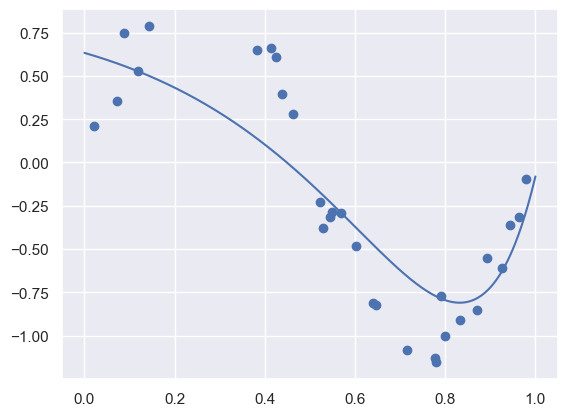

In [6]:
result2 = model.fit_regularized(alpha=0.01, L1_wt=0)
print(result2.params)
plot_statsmodels(result2)

반대로 모수 `L1_wt`가 1이면 순수 Lasso 모형이 된다.

Intercept    0.687949
x           -1.129134
I(x ** 2)   -1.124878
I(x ** 3)    0.000000
I(x ** 4)    0.000000
I(x ** 5)    0.000000
I(x ** 6)    0.000000
I(x ** 7)    0.000000
I(x ** 8)    0.281484
I(x ** 9)    1.075281
dtype: float64


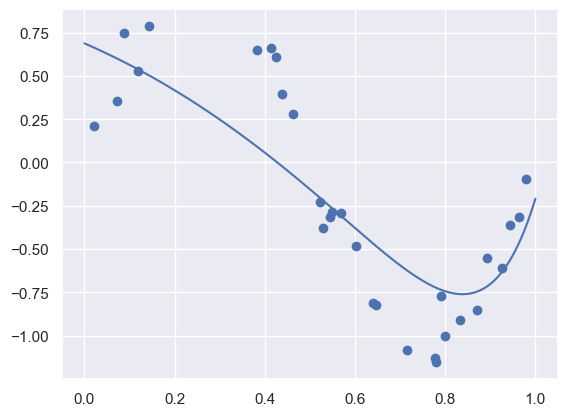

In [7]:
result3 = model.fit_regularized(alpha=0.01, L1_wt=1)
print(result3.params)
plot_statsmodels(result3)

Intercept    0.643465
x           -0.710209
I(x ** 2)   -1.162427
I(x ** 3)   -0.821070
I(x ** 4)   -0.326020
I(x ** 5)    0.003269
I(x ** 6)    0.327743
I(x ** 7)    0.547024
I(x ** 8)    0.681195
I(x ** 9)    0.751854
dtype: float64


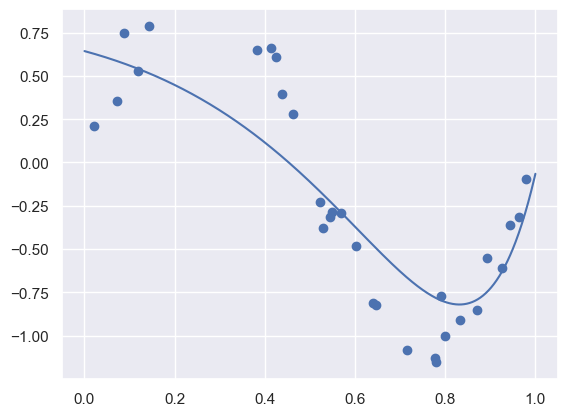

In [8]:
result4 = model.fit_regularized(alpha=0.01, L1_wt=0.05)
print(result4.params)
plot_statsmodels(result4)

<p>&nbsp;</p>

__Scikit-Learn의 정규화 회귀모형__

---

Scikit-Learn 패키지에서는 정규화 회귀모형을 위한 `Ridge`, `Lasso`, `ElasticNet` 이라는 별도의 클래스를 제공한다. 각 모형의 대한 최적화 목적 함수는 다음과 같다.

> `Ridge`

* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

$$
\text{RSS} + \alpha \sum w^2_i
$$

> `Lasso`

* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

$$
0.5 \times \text{RSS} / \text{N} + \alpha \sum |w_i|
$$

> `ElasticNet`

* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html

$$
0.5 \times \text{RSS} / \text{N}  + 0.5 \times \text{alpha} \times (0.5 \times (1 - \text{l1} \_ \text{ratio}) \sum w^2_i + \text{l1} \_ \text{ratio} \sum |w_i|)
$$


In [9]:
def plot_sklearn(model):
    plt.scatter(X, y)
    xx = np.linspace(0, 1, 1000)
    plt. plot(xx, model.predict(xx[:, np.newaxis]))
    plt.show()

[ 0.00000000e+00  2.57357731e+01 -4.28141684e+02  3.86672312e+03
 -1.83409397e+04  4.93260726e+04 -7.88847431e+04  7.45386452e+04
 -3.84531322e+04  8.35025499e+03]


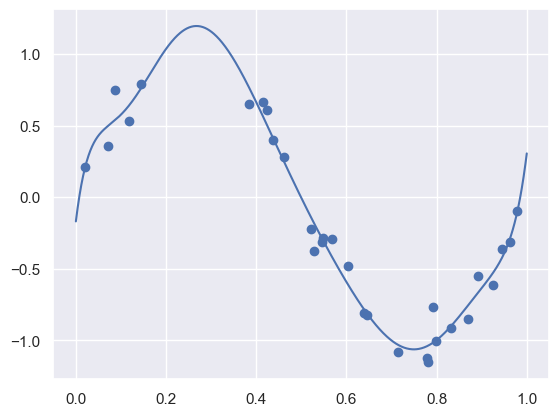

In [10]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

poly = PolynomialFeatures(9)
model = make_pipeline(poly, LinearRegression()).fit(X, y)
print(model.steps[1][1].coef_)
plot_sklearn(model)

[ 0.          1.51430399 -3.90160797 -2.6359859  -0.41526792  1.07530175
  1.64913273  1.52026782  0.94651401  0.13299614]


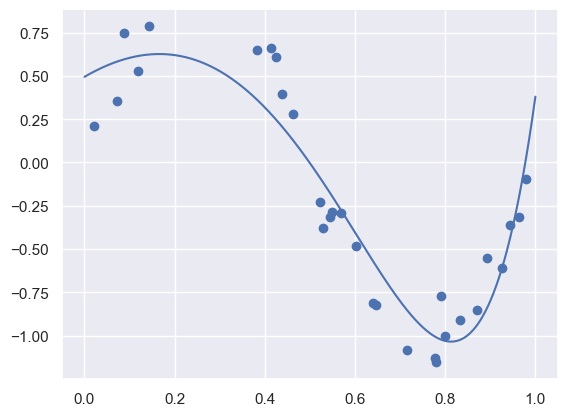

In [11]:
model =make_pipeline(poly, Ridge(alpha=0.01)).fit(X, y)
print(model.steps[1][1].coef_)
plot_sklearn(model)

[ 0.         -0.07668852 -2.44096313 -0.         -0.          0.
  0.          0.          0.          1.88188725]


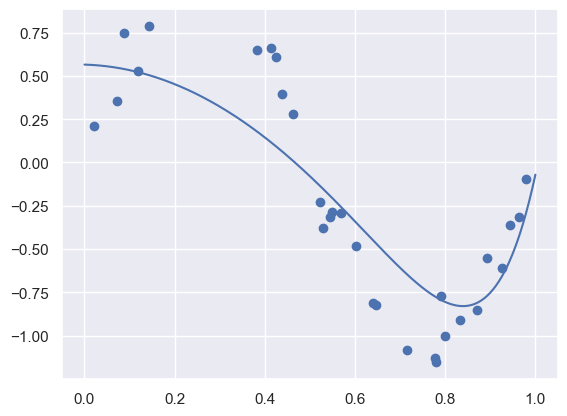

In [12]:
model = make_pipeline(poly, Lasso(alpha=0.01)).fit(X, y)
print(model.steps[1][1].coef_)
plot_sklearn(model)

[ 0.         -0.83768018 -1.23944649 -0.50166684 -0.          0.
  0.          0.30382246  0.62459231  0.84262899]


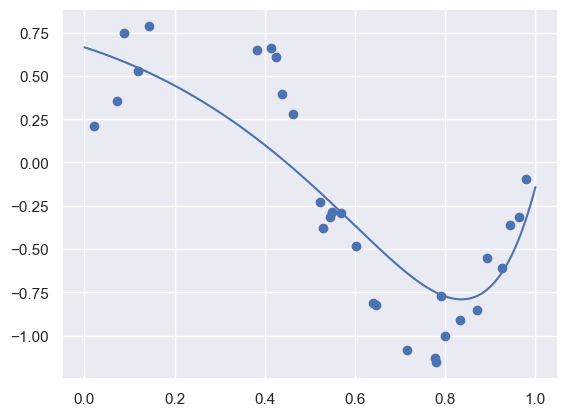

In [13]:
model = make_pipeline(poly, ElasticNet(alpha=0.01, l1_ratio=0.5)).fit(X, y)
print(model.steps[1][1].coef_)
plot_sklearn(model)

<p>&nbsp;</p>

__`PolynomialFeatrues`__

---

`PolynomialFeatures`는 scikit-learn의 `sklearn.preprocessing` 모듈에 포함된 클래스로, 다항식 특성을 생성하는 변환기입니다. 다항식 특성은 기존의 특성들을 사용하여 다항식 형태로 새로운 특성들을 생성하는 과정을 말합니다. 이를 통해 선형 모델을 사용하여 비선형 관계를 모델링할 수 있습니다.

`PolynomialFeatures`는 다음과 같은 매개변수를 가지고 있습니다:

`degree`: 생성할 다항식의 차수를 지정합니다. 예를 들어, `degree=2`로 설정하면 기존 특성의 제곱항까지 고려한 다항식 특성이 생성됩니다.

`interaction_only`: 기본값은 `False`이며, `True`로 설정하면 상호작용(interaction) 항만 생성됩니다. 예를 들어, 두 개의 특성 `x`와 `y`가 있다면, `interaction_only=True`로 설정하면 `x*y`와 같은 항이 생성됩니다.

`PolynomialFeatures`를 사용하면 데이터셋에 다항식 특성을 추가하여 모델의 표현력을 높일 수 있습니다. 예를 들어, 단순한 선형 회귀 모델로는 데이터가 비선형 관계를 가질 때 표현력이 부족할 수 있습니다. 이런 경우, `PolynomialFeatures`를 활용하여 다항식 특성을 생성하면 모델이 데이터의 곡선 형태를 더 잘 표현할 수 있습니다.

`PolynomialFeatures`가 원본 특성으로부터 다항식 특성을 생성하는 과정

하나의 특성 `x`를 가진 데이터셋이 있다고 가정하고, 최대 2차까지의 다항식 특성을 생성하려고 합니다. 다음은 단계별로 진행되는 과정입니다.

1. 원본 데이터:
   ```
   x
   --
   1.0
   2.0
   3.0
   ```

2. `PolynomialFeatures`를 `degree=2`로 적용:

   `PolynomialFeatures`는 입력된 특성들의 다항식 조합을 지정된 차수까지 생성합니다. 2차의 경우, 원본 특성과 그 제곱항을 생성합니다.

   ```
   x^0, x^1, x^2
   --------------
   1.0, 1.0, 1.0
   1.0, 2.0, 4.0
   1.0, 3.0, 9.0
   ```

   여기서 `x^0`는 상수 항(1)을 나타내며, `x^1`은 원본 특성 `x`를 나타내고, `x^2`는 `x`의 제곱 항입니다.

3. 생성된 다항식 특성:

   생성된 데이터셋은 이제 원본 특성과 그 제곱 항을 포함한 새로운 특성들을 가지게 됩니다.

   ```
   x^0  x^1  x^2
   --------------
   1.0, 1.0, 1.0
   1.0, 2.0, 4.0
   1.0, 3.0, 9.0
   ```

이러한 과정은 더 높은 차수로 확장될 수 있습니다. 예를 들어, `degree=3`으로 설정하면 `PolynomialFeatures`는 각 데이터 포인트에 대해 세제곱 항 (`x^3`)을 추가로 생성합니다.

이러한 특성 확장을 통해 선형 모델이 특성과 타겟 변수 간 보다 복잡한 관계를 파악할 수 있습니다. 차수를 늘리면 모델이 데이터 내의 잡음까지 학습하는 과적합도 주의해야 합니다.

<p>&nbsp;<p>

__`make_pipeline`__

---

`make_pipeline` 함수의 매개변수들은 파이프라인을 생성할 때 사용되는 것들입니다. 파이프라인은 데이터 처리 및 모델링 작업을 순차적으로 연결해주는 유용한 도구입니다.

1. **`*steps`**: 파이프라인 내에서 수행될 작업들을 지정합니다. 이 매개변수는 여러 개의 변환기(transformer)와 추정기(estimator) 객체들을 인자로 받을 수 있습니다. 파이프라인은 이러한 객체들을 순차적으로 연결하여 데이터를 처리하고 모델을 훈련시킵니다.

2. **`memory`**: 결과를 캐싱하여 중복된 계산을 피할 때 사용됩니다. 이 매개변수에는 캐싱된 결과를 저장할 디렉토리 경로를 지정할 수 있습니다.

3. **`verbose`**: 파이프라인 실행 과정을 자세하게 출력할지 여부를 결정합니다. 숫자 값(0, 1, 2)을 사용하여 출력 레벨을 조절할 수 있습니다. 값이 클수록 더 많은 정보가 출력됩니다.

예를 들어, 다음과 같이 `make_pipeline` 함수를 사용하여 파이프라인을 생성할 수 있습니다:

```python
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# 변환기와 추정기를 순차적으로 연결하는 파이프라인 생성
pipeline = make_pipeline(
    StandardScaler(),   # 데이터 스케일링 변환기
    LogisticRegression()  # 로지스틱 회귀 추정기
)
```

이 예제에서는 데이터 스케일링 변환기와 로지스틱 회귀 추정기를 순차적으로 연결하여 파이프라인을 생성하고 있습니다. 이렇게 생성된 파이프라인은 데이터를 스케일링한 후 로지스틱 회귀 모델을 훈련시킵니다.

`steps` 속성은 scikit-learn의 `Pipeline` 클래스의 속성입니다. 파이프라인은 데이터 처리 단계의 시퀀스로, 각 단계는 이름(문자열)과 추정기(알고리즘 또는 변환)의 인스턴스로 구성된 튜플입니다. `steps` 속성을 사용하면 이러한 튜플의 리스트에 액세스할 수 있습니다.

당신의 코드에서:

```python
model = make_pipeline(poly, LinearRegression()).fit(X, y)
print(model.steps[1][1].coef_)
```

`model`은 `make_pipeline` 함수를 사용하여 생성된 파이프라인입니다. 이 파이프라인은 두 단계로 구성됩니다:

1. 첫 번째 단계 (`model.steps[0]`)는 PolynomialFeatures 변환 (`poly`)입니다.
2. 두 번째 단계 (`model.steps[1]`)는 LinearRegression 추정기입니다.

`model.steps[1][1].coef_`는 LinearRegression 추정기의 계수를 검색합니다. 이 계수는 선형 회귀 모델에서 각 특성에 할당된 가중치입니다.

`model.steps[1][1].coef_` 라인에서 대괄호 안의 숫자는 인덱스를 나타냅니다. 다음과 같이 설명할 수 있습니다:

- `model.steps[1]`은 파이프라인에서 두 번째 단계를 가리킵니다.
- `model.steps[1][1]`은 그 두 번째 단계 내의 추정기에 접근합니다.

scikit-learn의 파이프라인에서 단계들은 리스트로 저장되며, 각 단계는 이름과 추정기로 구성된 튜플입니다. `[1]` 인덱스는 튜플 내의 추정기에 접근하며, 다시 `[1]`은 그 추정기 내의 `coef_` 속성에 접근합니다. 이 값들은 선형 회귀 모델의 계수입니다.

따라서 당신의 특정한 코드에서 `model.steps[1][1].coef_`는 파이프라인의 두 번째 단계 내에 있는 LinearRegression 추정기의 계수를 가져오는 것입니다.

<p>&nbsp;</p>

__정규화 모형의 장점__

---

정규화 모형은 회귀 분석에 사용된 데이터가 달라져도 계수가 크게 달라지지 않도록  한다.

<p>&nbsp;</p>

__정규화의 의미__

---

정규화 제한조건은 정규화가 없는 최적화 문제에 부등식 제한조건을 추가한 것과 마찬가지이다. 즉, 릿지 회귀모형은

$$
w = \text{arg} \min_w \left( \sum^N_{i=1} e^2_i\right)
$$

이라는 최적화 문제에 다음과 같은 부등식 제한조건을 추가한 것과 같다.

$$
\sum^M_{j=1} w^2_j \leq C
$$

라그랑지 방법을 사용하면 앞의 부등식 제한조건이 있는 최적화 문제는 다음과 같은 부등식 제한조건이 없는 최적화 문제가 된다.

$$
w = \text{arg} \min_w \left( \sum^N_{i=1} e^2_i + \lambda \left( \sum^M_{j=1} w^2_j - C \right) \right)
\\
= \text{arg} \min_w \left( \sum^N_{i=1} e^2_i + \lambda \sum^M_{j=1} w^2_j - \lambda C \right)
$$

<p>&nbsp;</p>

__Ridge 모형과 Lasso 모형의 차이__

---

Ridge 모형은 가중치 계수를 한꺼번에 축소시키는데 반해 Lasso 모형은 일부 가중치 계수가 먼저 0으로 수렴하는 특성이 있다.


In [14]:
from sklearn.datasets import load_diabetes
diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target

In [15]:
alpha = np.logspace(-3, 1, 5)

data = []
for i, a in enumerate(alpha):
    ridge = Ridge(alpha=a).fit(X, y)
    data.append(pd.Series(np.hstack([ridge.intercept_, ridge.coef_])))

df_ridge = pd.DataFrame(data, index=alpha).T
df_ridge

,0.001,0.010,0.100,1.000,10.000
0,152.133484,152.133484,152.133484,152.133484,152.133484
1,-9.549162,-7.197534,1.308705,29.466112,19.812842
2,-239.086958,-234.549764,-207.192418,-83.154276,-0.918430
3,520.369375,520.588601,489.695171,306.352680,75.416214
4,323.822745,320.517131,301.764058,201.627734,55.025160
5,-712.322159,-380.607135,-83.466034,5.909614,19.924621
6,413.379125,150.484671,-70.826832,-29.515495,13.948715
7,65.811323,-78.589275,-188.678898,-152.040280,-47.553816
8,167.513007,130.312521,115.712136,117.311732,48.259433
9,720.939924,592.347959,443.812917,262.944290,70.143948


In [16]:
alpha = np.logspace(-3, 1, 5)

data = []
for i, a in enumerate(alpha):
    lasso = Lasso(alpha=a).fit(X, y)
    data.append(pd.Series(np.hstack([lasso.intercept_, lasso.coef_])))

df_lasso = pd.DataFrame(data, index=alpha).T
df_lasso

,0.001,0.010,0.100,1.000,10.000
0,152.133484,152.133484,152.133484,152.133484,152.133484
1,-8.996177,-1.304662,-0.000000,0.000000,0.000000
2,-238.896328,-228.819129,-155.359976,-0.000000,0.000000
3,520.267403,525.566130,517.186795,367.703860,0.000000
4,323.423596,316.168834,275.077235,6.298858,0.000000
5,-720.244828,-307.016211,-52.539365,0.000000,0.000000
6,421.399753,89.324647,-0.000000,0.000000,0.000000
7,66.733503,-105.078369,-210.157991,-0.000000,-0.000000
8,164.448022,119.597616,0.000000,0.000000,0.000000
9,725.335558,571.330356,483.912648,307.605418,0.000000


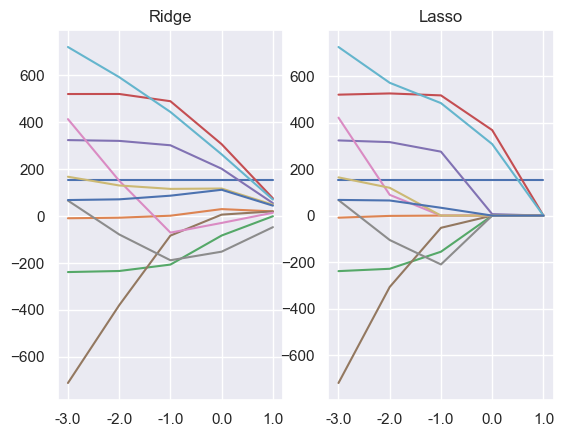

In [17]:
ax1 = plt.subplot(121)
plt.semilogx(df_ridge.T)
plt.xticks(alpha, labels=np.log10(alpha))
plt.title("Ridge")

ax2 = plt.subplot(122)
plt.semilogx(df_lasso.T)
plt.xticks(alpha, labels=np.log10(alpha))
plt.title("Lasso")

plt.show()

<p>&nbsp;</p>

__최적 정규화__

---

정규화에 사용되는 하이퍼 모수(hyper parameter) 등을 바꾸면 모형의 검증 성능이 달라진다. 따라서 최적의 성능을 가져올 수 있는 정규화 하이퍼 모수를 선택하는 과정이 필요하다. 이러한 과정을 최적 정규화(optimal regularization)라고 한다.

캘리포니아 집값 데이터에 대해 라쏘 정규화(Lasso regularization)를 하는 경우를 예로 들어보자 우선 scikit-learn에서 제공하는 `Lasso` 클래스를 사용하여 정규화를 한다. 정규화 가중치 $\alpha$가 달라지면 학습용 데이터를 사용한 성능과 검증용 데이터를 사용한 성능이 달라진다.

* 학습용 데이터를 사용한 성능은 정규화 가중치 $\alpha$가 작으면 작을 수록 좋아진다.(과최적화)

* 검증용 데이터를 사용한 성능은 정규화 가중치 $\alpha$가 특정한 범위에 있을 때 가장 좋아진다.

실제로 정규화 가중치 $\alpha$를 $10^{-3}$부터 $10^{-0.5}$까지 변화시켜가면서 두 성능을 측정해 보자.


c:\Users\tg\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tg\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44508 (\N{HANGUL SYLLABLE GYU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tg\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tg\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tg\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarni

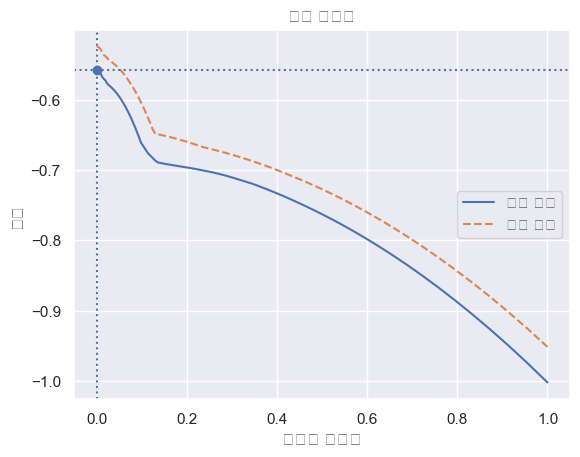

In [18]:
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

cali = fetch_california_housing()
X = cali.data
y = cali.target

alphas = np.logspace(-4, 0, 200)

train_scores = []
test_scores = []
for alpha in alphas:
    model = Lasso(alpha=alpha)
    train_score = -mean_squared_error(y, model.fit(X, y).predict(X))
    test_score = np.mean(cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5))
    train_scores.append(train_score)
    test_scores.append(test_score)

optimal_alpha = alphas[np.argmax(test_scores)]
optimal_score = np.max(test_scores)

plt.plot(alphas, test_scores, "-", label="검증 성능")
plt.plot(alphas, train_scores, "--", label="학습 성능")
plt.axhline(optimal_score, linestyle=':')
plt.axvline(optimal_alpha, linestyle=':')
plt.scatter(optimal_alpha, optimal_score)
plt.title("최적 정규화")
plt.ylabel('성능')
plt.xlabel('정규화 가중치')
plt.legend()
plt.show()